In [3]:
import h3
import h3pandas
import rasterio 
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pydeck as pdk
from rasterio.plot import show

c:\Users\User\anaconda3\envs\scip\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [4]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

### 1. Transform raster layer to Dataframe of pixel centroids

In [5]:
def raster_to_df(raster_file):
    """
    Need to revise this process! 
    The input raster needs to already be in epsg:4326 in order for this to work. This means for now the suitability critieria raster layers
    (e.g. distance to farm etc.) need to be exported first as a raster layer without inf value (replace inf with zero for background values). 
    Then the non-inf raster layer should be imported to ArcGis to be reprojected into epsg:4326.  
    """
    with rasterio.open(raster_file) as src:
        band1 = src.read(1)
        # bbox = src.bounds
        print(src.meta)
        cols, rows = np.meshgrid(np.arange(band1.shape[1]), np.arange(band1.shape[0]))
        xs, ys = rasterio.transform.xy(src.transform, rows, cols)
        lons = np.array(xs)
        lats = np.array(ys)
    
    # Flatten the arrays and create a DataFrame
    df = pd.DataFrame({
       'lat': lats.flatten(),
       'lon': lons.flatten(),
       'value': band1.flatten()})
    
    # Filter out no-data values (if no-data values are zero)
    df = df[df['value'] != src.nodatavals[0]]
    df = df[~np.isinf(df['value'])]

    # Filter out no-data values (if no-data values are inf)
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # # Drop rows with NaN
    # df.dropna(inplace=True)
    
    return band1, df

In [4]:
raster_file = './raster/proximity_road_4326.tif'

In [5]:
band1, df = raster_to_df(raster_file)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1338, 'height': 721, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0007655152278480028, 0.0, 6.186991639930978,
       0.0, -0.0007655152278480028, 52.580451278111624)}


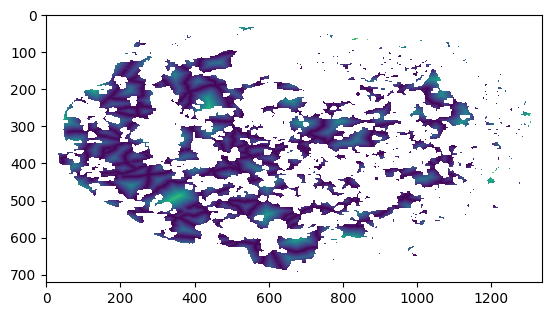

<Axes: >

In [6]:
show(band1)

In [7]:
df

,lat,lon,value
42006,52.556338,6.591566,4573.511719
42007,52.556338,6.592332,4534.693848
42183,52.556338,6.727063,4065.321289
42184,52.556338,6.727828,4012.599609
42185,52.556338,6.728594,4012.599609
...,...,...,...
933287,52.046504,6.724001,2603.843018
933288,52.046504,6.724766,2690.629150
933289,52.046504,6.725532,2778.303711
933290,52.046504,6.726297,2866.785400


### 2. Find H3 hexagon containing the raster centroids
Indexes the location at the specified resolution, returning the index of the cell containing the location. This buckets the geographic point into the H3 grid. See the algorithm description for more information.

In [7]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

In [8]:
# Using centroids of raster cells, find H3 indices that contain the centroid
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, APERTURE_SIZE),1)

In [9]:
# Group by H3 indices and take average values of raster centroid cells 
hex_df = df.groupby(hex_col)['value'].mean().to_frame('value')

In [11]:
# Get H3 centroid and boundary geometry 
hex_df = hex_df.h3.h3_to_geo()
hex_df['geometry_boundary'] = hex_df.h3.h3_to_geo_boundary().geometry

In [12]:
twente = gpd.read_file("/Users/User/Desktop/BIOZE/data/gemeente_and_boundaries/twente_boundaries/Boundaries_Twente.shp")
twente = twente.to_crs('EPSG:4326')

In [13]:
hex_gdf = gpd.GeoDataFrame(hex_df, geometry='geometry', crs='EPSG:4326')

In [17]:
# Crop the DataFrame using the Twente boundary GeoDataFrame to get rid of the buffer
hex_crop = gpd.clip(hex_gdf, twente).reset_index()

In [22]:
# This is a GeoDataframe that stores the list of H3 indices relevant for our study, as well as each index's centroid geometry
h3_list = hex_crop[['hex9','geometry']]
h3_list.to_file('./h3_list.shp')

In [18]:
hex_crop

,hex9,value,geometry,geometry_boundary
0,891f1655aa3ffff,39.450001,POINT (6.72402 52.11835),"POLYGON ((6.72147 52.11887, 6.72175 52.11726, ..."
1,891f1655a87ffff,31.647675,POINT (6.71636 52.11990),"POLYGON ((6.71381 52.12042, 6.71409 52.11881, ..."
2,891f1655ab3ffff,16.799999,POINT (6.72119 52.12048),"POLYGON ((6.71864 52.12099, 6.71891 52.11939, ..."
3,891f1655ab7ffff,33.058701,POINT (6.72601 52.12106),"POLYGON ((6.72346 52.12157, 6.72374 52.11996, ..."
4,891f1655a97ffff,15.643626,POINT (6.71353 52.12202),"POLYGON ((6.71098 52.12254, 6.71126 52.12093, ..."
...,...,...,...,...
16660,891f1612b6bffff,20.715565,POINT (6.98352 52.46120),"POLYGON ((6.98096 52.46172, 6.98123 52.46011, ..."
16661,891f1612b6fffff,25.109451,POINT (6.98839 52.46177),"POLYGON ((6.98582 52.46229, 6.98609 52.46068, ..."
16662,891f1612b7bffff,8.927562,POINT (6.98068 52.46332),"POLYGON ((6.97811 52.46383, 6.97839 52.46223, ..."
16663,891f1610ca3ffff,6.475256,POINT (6.97665 52.45794),"POLYGON ((6.97408 52.45846, 6.97436 52.45686, ..."


### Using h3_list to convert other raster layers to H3 

In [6]:
band1, df = raster_to_df('./raster/proximity_urban_4326.tif')

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': inf, 'width': 1338, 'height': 721, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0007655152278480028, 0.0, 6.186991639930978,
       0.0, -0.0007655152278480028, 52.580451278111624)}


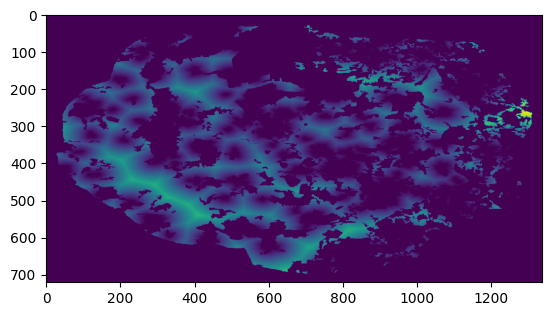

<Axes: >

In [64]:
show(band1)

In [65]:
# Using centroids of raster cells, find H3 indices that contain the centroid
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, APERTURE_SIZE),1)

In [66]:
# Step 1: Identify Rows with Matching H3 Indices
# merged_df = pd.merge(df, h3_list.explode('hex9'), left_on='hex9', right_on='hex9', how='right')
merged_df = pd.merge(df, h3_list, on='hex9', how='right')

In [67]:
# Step 2: GroupBy and Calculate Average
hex = merged_df.groupby('hex9')['value'].mean().reset_index()

In [68]:
hex

,hex9,value
0,891f1600093ffff,32.888489
1,891f1600097ffff,7.102304
2,891f16000a3ffff,4.872100
3,891f16000a7ffff,48.670052
4,891f16000afffff,3.024466
...,...,...
11623,891f16d5ec7ffff,7.323794
11624,891f16d5ecbffff,0.100000
11625,891f16d5ecfffff,3.965214
11626,891f16d5ed3ffff,0.400677


### 3. Get colors based on values

In [69]:
colormap_name = 'magma'

In [24]:
def get_fill_color(df, value_column, colormap_name):
    # Calculate min, max, and diff
    min_value = df[value_column].min()
    max_value = df[value_column].max()
    diff = max_value - min_value

    # Obtain colormap
    cmap = plt.get_cmap(colormap_name)

    # Define a normalization function for the data range
    norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

    # Function to convert data values to RGB using reversed colormap
    def get_rgb_reversed(value):
        rgba = cmap(1 - norm(value))
        return [int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255)]

    # Apply the function to the DataFrame to get RGB values
    df['color'] = df[value_column].apply(get_rgb_reversed)

In [5]:
# hex_df = pd.read_csv('./hex/d_to_farm_hex_complete.csv')

In [25]:
get_fill_color(hex_crop, "value", "magma")

### 3. Save the file

In [70]:
# save
hex.to_csv('./hex/urban_v2.csv')

In [65]:
hex_crop = hex_crop.reset_index()

### 4. Visualize the hexagons

In [30]:
# Define a layer to display on a map
layer = pdk.Layer(
    "H3HexagonLayer",
    hex_crop[['hex9', 'value', 'color']],
    pickable=True,
    # stroked=True,
    filled=True,
    extruded=False,
    auto_highlight=True,
    opacity=0.6,
    get_hexagon="hex9",
    get_fill_color = "color", 
    get_line_color=[255, 255, 255],
    line_width_min_pixels=0.1
    )


# Set the viewport location
view_state = pdk.ViewState(longitude=6.747489560596507, latitude=52.316862707395394, zoom=9, bearing=0, pitch=0)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "Count: {value}"})
r.to_html("h3_hexagon_layer_cropped_new.html")

In [7]:
# def cell_to_shapely(cell):
#     coords = h3.h3_to_geo_boundary(cell)
#     flipped = tuple(coord[::-1] for coord in coords)
#     return Polygon(flipped)

In [8]:
# hex_geoms = hex['hex'].apply(lambda x: cell_to_shapely(x))
# h3_gdf = gpd.GeoDataFrame(data=hex, geometry=hex_geoms, crs=4326)
# h3_gdf.head()

In [9]:
# h3_gdf.plot()

### Export raster layer without inf values

In [2]:
og_raster = "./raster/d_to_inlet.tif"

In [3]:
with rasterio.open(og_raster) as src:
    band1 = src.read(1)

In [4]:
band1[np.isinf(band1)] = 0

In [5]:
# Open the original raster file
with rasterio.open(og_raster) as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    # \Users\User\Desktop\BIOZE\new_rasters
    with rasterio.open('/Users/User/Desktop/BIOZE/new_rasters/d_to_inlet_3846_nonzero.tif', 'w', **profile) as dst:
        dst.write(band1, 1)

### End of section

### Fuzzify the variables

In [126]:
# Transform distance to farm and road into numpy array
d_to_farm = np.array(farm_hex['Value'])
d_to_road = np.array(road_hex['Value'])

In [127]:
fuzzy_farm = np.maximum(0, 1 - (d_to_farm - d_to_farm.min()) / (d_to_farm.max() - d_to_farm.min()))
fuzzy_road = np.maximum(0, 1 - (d_to_road - d_to_road.min()) / (d_to_road.max() - d_to_road.min()))

In [ ]:
def fuzzify(df):
    df_array = np.array(df['Value'])
    fuzzified_array = np.maximum(0, 1 - (df_array - df_array.min()) / (df_array.max() - df_array.min()))
    return fuzzified_array

In [ ]:
def fuzzy_analysis_hex(*args, hex_df):
    # Fuzzy operation AND
    fuzzy = np.minimum(args)
    # # Find the indices of non-inf values in original raster layer
    # non_inf_indices = np.where(np.isfinite(og_raster))
    hex_df['fuzzy'] = fuzzy
    return hex_df

In [131]:
fuzzy = np.minimum(fuzzy_farm, fuzzy_road)

In [134]:
fuzzy_hex = farm_hex.copy()

In [135]:
fuzzy_hex

,Unnamed: 0,hex9,Value
0,0,891f1618003ffff,2381.4856
1,1,891f161800bffff,2337.3857
2,2,891f1618013ffff,2218.8733
3,3,891f1618017ffff,2436.8770
4,4,891f161801bffff,2114.2710
...,...,...,...
280,280,891f161b627ffff,2913.5730
281,281,891f161b62bffff,3391.3794
282,282,891f161b62fffff,3089.9436
283,283,891f161b633ffff,3285.7136


In [137]:
fuzzy_hex['fuzzy'] = fuzzy
fuzzy_hex = fuzzy_hex.drop(['Unnamed: 0', 'Value'], axis=1)

In [138]:
fuzzy_hex

,hex9,fuzzy
0,891f1618003ffff,0.043984
1,891f161800bffff,0.031908
2,891f1618013ffff,0.147255
3,891f1618017ffff,0.052841
4,891f161801bffff,0.147676
...,...,...
280,891f161b627ffff,0.164346
281,891f161b62bffff,0.022344
282,891f161b62fffff,0.111929
283,891f161b633ffff,0.053747


Text(0, 0.5, 'Frequency')

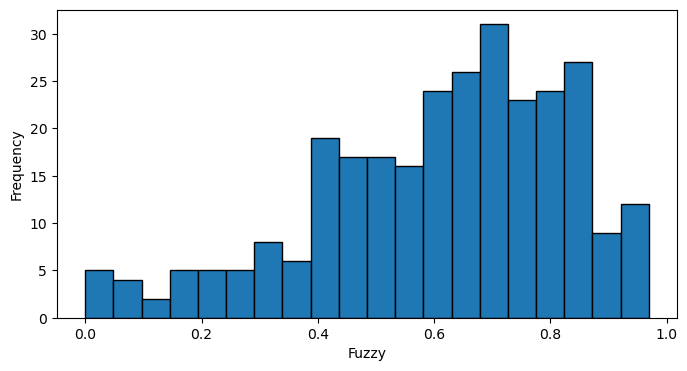

In [146]:
# Create subplots
plt.figure(figsize=(8, 4))
plt.hist(fuzzy, bins=20, edgecolor='black')
plt.xlabel('Fuzzy')
plt.ylabel('Frequency')

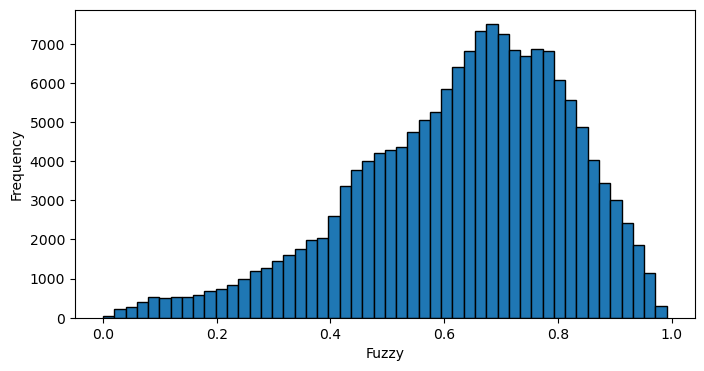

In [147]:
with rasterio.open("./raster/fuzzy_and_1.tif") as src:
    band1 = src.read(1)
    # Create subplots
    plt.figure(figsize=(8, 4))
    plt.hist(band1[np.isfinite(band1)], bins=50, edgecolor='black')
    plt.xlabel('Fuzzy')
    plt.ylabel('Frequency')

In [130]:
def fuzzy_analysis(*args, og_raster, og_raster_path, new_raster_path):
    """
    This is the fuzzy analysis function to perform on raster layer. 
    args: arrays of fuzzified criteria 
    """
    # Fuzzy operation AND
    fuzzy = np.minimum(args)
    # Find the indices of non-inf values in original raster layer
    non_inf_indices = np.where(np.isfinite(og_raster))
    
    if len(fuzzy) == len(non_inf_indices[0]):
        # Replace the non-inf values in original raster layer with fuzzy values
        m = np.copy(og_raster)
        m[non_inf_indices] = fuzzy
    else:
        print("Can not proceed")
    
    # Save the fuzzy array 
    with rasterio.open(og_raster_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.float32, count=1)
        with rasterio.open(new_raster_path, 'w', **profile) as dst:
            dst.write(m, 1)
    return fuzzy

In [2]:
farm_hex = pd.read_csv('./hex/d_to_farm_hex.csv')
road_hex = pd.read_csv('./hex/d_to_road_hex.csv')
fake_hex = pd.read_csv('./hex/fake_hex.csv')

In [3]:
def fuzzify(df):
    df_array = np.array(df['Value'])
    fuzzified_array = np.maximum(0, 1 - (df_array - df_array.min()) / (df_array.max() - df_array.min()))
    return fuzzified_array

def fuzzy_analysis_hex(*args):
    # Fuzzy operation AND
    fuzzy = np.minimum(args)
    return fuzzy 

In [5]:
fuzzy_farm = fuzzify(farm_hex)
fuzzy_road = fuzzify(road_hex)
fuzzy_fake = fuzzify(fake_hex)

In [6]:
all_arrays = {'Farm': fuzzy_farm, 'Road': fuzzy_road, 'Fake': fuzzy_fake}

In [13]:
# Create multiple arrays
array1 = np.array([1, 5, 3, 8])
array2 = np.array([2, 4, 1, 7])
array3 = np.array([0, 6, 2, 9])

# Store arrays in a list
array_list = [array1, array2, array3]

In [18]:
data_dict = {'Farm': array1,
             'City':array2,
             'Village': array3}

In [20]:
# Your list of keys
keys_to_extract = ['Farm', 'City']

In [21]:
# Extract arrays using a list comprehension
arrays_to_extract = [data_dict[key] for key in keys_to_extract]

# Now arrays_to_extract contains the arrays corresponding to the keys in the list
for key, arr in zip(keys_to_extract, arrays_to_extract):
    print(f"{key}: {arr}")

Farm: [1 5 3 8]
City: [2 4 1 7]


In [23]:
# Use a loop to compute the element-wise minimum
result_array = array_list[0]  # Initialize with the first array

In [26]:
for arr in array_list[1:]:
    result_array = np.minimum(result_array, arr)

print("Original Arrays:")
for i, arr in enumerate(array_list, start=1):
    print(f"Array {i}:", arr)

print("\nElement-wise Minimum:")
print("Result Array:", result_array)

Original Arrays:
Array 1: [1 5 3 8]
Array 2: [2 4 1 7]
Array 3: [0 6 2 9]

Element-wise Minimum:
Result Array: [0 4 1 7]


In [27]:
def fuzzify(df):
    df_array = np.array(df['Value'])
    fuzzified_array = np.maximum(0, 1 - (df_array - df_array.min()) / (df_array.max() - df_array.min()))
    return fuzzified_array

In [29]:
fuzzy_farm = fuzzify(farm_hex)

In [31]:
fuzzy_farm.shape

(285,)

In [32]:
farm_hex

,Unnamed: 0,hex9,Value
0,0,891f1618003ffff,2381.4856
1,1,891f161800bffff,2337.3857
2,2,891f1618013ffff,2218.8733
3,3,891f1618017ffff,2436.8770
4,4,891f161801bffff,2114.2710
...,...,...,...
280,280,891f161b627ffff,2913.5730
281,281,891f161b62bffff,3391.3794
282,282,891f161b62fffff,3089.9436
283,283,891f161b633ffff,3285.7136


In [33]:
df = farm_hex[['hex9']]
df

,hex9
0,891f1618003ffff
1,891f161800bffff
2,891f1618013ffff
3,891f1618017ffff
4,891f161801bffff
...,...
280,891f161b627ffff
281,891f161b62bffff
282,891f161b62fffff
283,891f161b633ffff
